In [17]:
import random
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import bcolz
import zarr
import os
import pandas as pd
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.1.8


In [18]:
release_dir = '/Volumes/Seagate Extra Storage/MalariaData/zarr2/'
callset_fn = os.path.join(release_dir, 'ag1000g.phase1.ar3.1.haplotypes')

In [19]:
callset = zarr.open_group(callset_fn, mode = 'r')
callset

Group(/, 6)
  arrays: 1; samples
  groups: 5; 2L, 2R, 3L, 3R, X
  store: DirectoryStore

In [20]:
df_samples = pd.DataFrame.from_csv('/Users/NaomiCannell/Desktop/samples.meta.txt', sep = '\t')
df_samples.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
index,,,,,,,,,,,,,,,
0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


In [21]:
aom = df_samples.query('population == "AOM"')
aom.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
index,,,,,,,,,,,,,,,
618,AR0007-C,LUA007,ERS224256,AOM,Angola,Luanda,Joao Pinto,NaN,2009,M,F,99082110,31.48,-8.821,13.291
619,AR0008-C,LUA008,ERS224129,AOM,Angola,Luanda,Joao Pinto,NaN,2009,M,F,91490260,29.21,-8.821,13.291
620,AR0009-C,LUA009,ERS224325,AOM,Angola,Luanda,Joao Pinto,NaN,2009,M,F,105932994,33.27,-8.821,13.291
621,AR0010-C,LUA010,ERS224099,AOM,Angola,Luanda,Joao Pinto,NaN,2009,M,F,115066732,37.74,-8.821,13.291
622,AR0011-C,LUA011,ERS224318,AOM,Angola,Luanda,Joao Pinto,NaN,2009,M,F,105048076,31.87,-8.821,13.291


In [22]:
def abv_prop(vals):
    if vals.size < 100:
        return np.nan
    vals = vals[~np.isnan(vals)]
    return (sum(vals>2)/len(vals))

In [23]:
accessibility = h5py.File('/Volumes/Seagate Extra Storage/MalariaData/zarr2/accessibility.h5', mode = 'r')

In [24]:
chroms = ['2L', '2R', '3L', '3R']

Part 1 Done
Part 2 Done
Part 3 Done
Step 4 done
Step 5 done
Step 6 done
Part 1 Done
Part 2 Done
Part 3 Done
Step 4 done
Step 5 done
Step 6 done
Part 1 Done
Part 2 Done
Part 3 Done
Step 4 done
Step 5 done
Step 6 done
Part 1 Done
Part 2 Done
Part 3 Done
Step 4 done
Step 5 done
Step 6 done


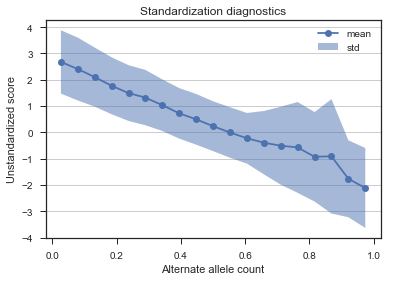

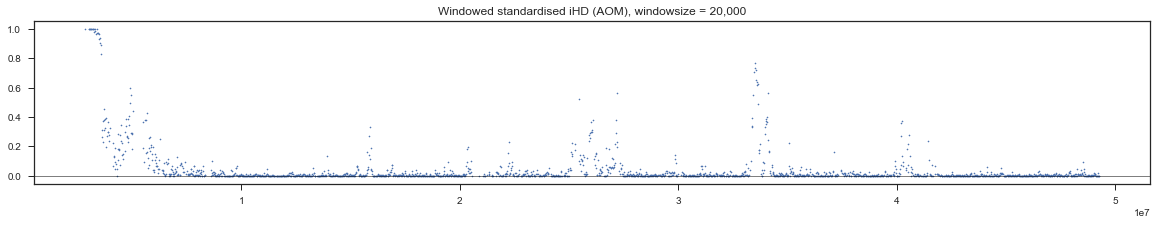

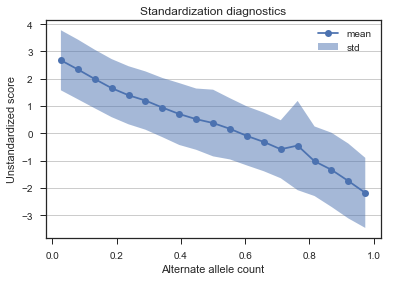

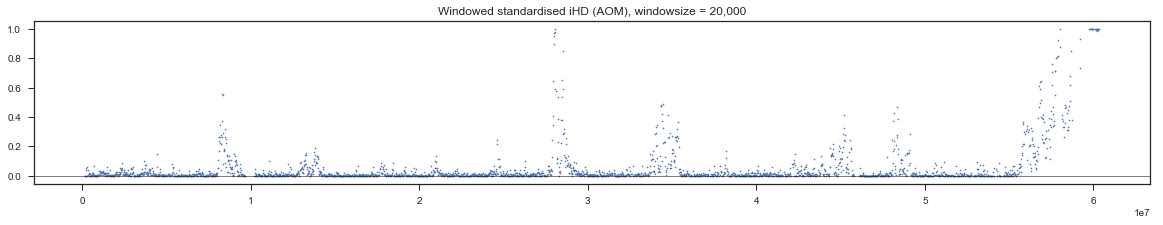

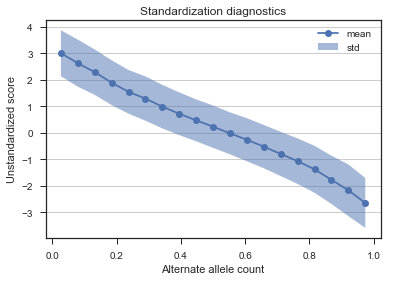

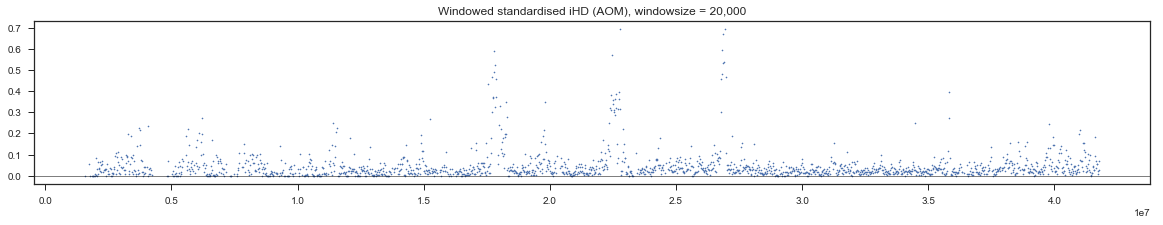

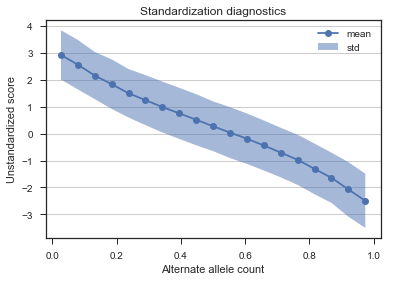

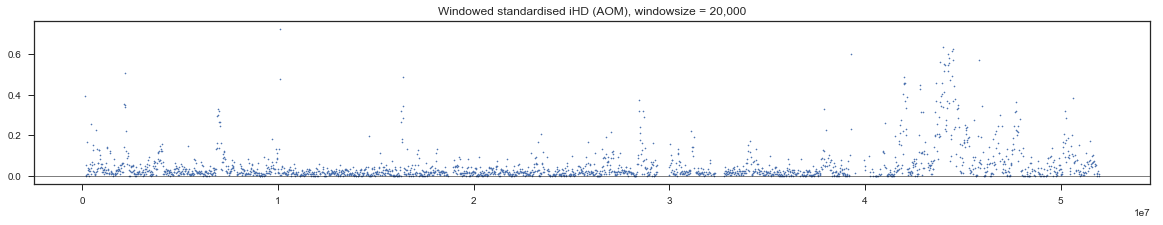

In [27]:
for chrom in chroms:
    #get genotypes and haplotypes without singletons and non-segregating alleles
    genotypes = allel.GenotypeChunkedArray(callset[chrom]['calldata']['genotype'])
    pop_genotypes = genotypes.take(aom.index, axis = 1)
    ac_pop = pop_genotypes.count_alleles(max_allele=1)[:]
    mac_pop = ac_pop.min(axis=1)
    num_single = mac_pop > 1
    genotypes_nosingle = pop_genotypes.compress(num_single, axis = 0)
    haplotypes = genotypes_nosingle.to_haplotypes()
    print('Part 1 Done')
    
    #get positions
    positions = allel.SortedIndex(callset[chrom]['variants/POS'])
    pos = positions.compress(num_single)
    print('Part 2 Done')
    
    #get chromosome accessibility
    chrom_accessibility = accessibility[chrom]['is_accessible']
    aom_ihs = allel.ihs(haplotypes, pos, use_threads = True, is_accessible = chrom_accessibility)
    print('Part 3 Done')
    
    #get alternative allele frequencies
    alcount_nof = ac_pop.compress(num_single)
    alt_freq = alcount_nof.to_frequencies()
    alt_freq=alt_freq[:,1]
    
    #compile the data into a dataframe
    newdata = pd.DataFrame(index = pos, columns = ['ihs', 'altfreq'])
    newdata.ihs = aom_ihs
    newdata.altfreq = alt_freq
    newdata = newdata.dropna()
    print('Step 4 done')
    
    #standardise
    standardised, bins = allel.standardize_by_allele_count(score=newdata.ihs, aac=newdata.altfreq, bins = np.linspace(0, 1, 20))
    newdata['std_ihs'] = standardised
    newdata.head()
    print('Step 5 done')
    
    #plot and save
    values, windows, counts = allel.stats.windowed_statistic(pos = newdata.index, values = abs(newdata.std_ihs), statistic = abv_prop, size = 20000)
    plt.figure(figsize = (20,3))
    plt.scatter(x = windows.mean(axis=1), y=values, s=1.5)
    plt.axhline(0, color = 'black', lw = 0.5)
    plt.title('Windowed standardised iHD (AOM), windowsize = 20,000')
    print('Step 6 done')
    
    fn = ''.join(['/Users/NaomiCannell/Desktop/aom/', chrom, '_aom.csv'])
    newdata.to_csv(fn)